In [2]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import morphology, measure
import os
import cv2
from scipy.ndimage import gaussian_filter, uniform_filter
from tqdm import tqdm
import time

In [3]:
sample_images= []
sample_masks = []
test_images= []
test_masks = []
data_dir = os.getcwd()  
sample_img_dir = os.path.join(data_dir, "Sample", "SampleImages")
sample_mask_dir = os.path.join(data_dir, "Sample", "SampleMasks")
test_img_dir = os.path.join(data_dir, "Test", "TestImages")
test_mask_dir = os.path.join(data_dir, "Test", "TestMasks")

for i in range(1, 16):
    sample_img_path = os.path.join(sample_img_dir, f"dwi_slice_{i}.nii.gz")
    sample_mask_path = os.path.join(sample_mask_dir, f"dwi_mask_{i}.nii.gz")
    test_img_path = os.path.join(test_img_dir, f"dwi_slice_{i}.nii.gz")
    test_mask_path = os.path.join(test_mask_dir, f"dwi_mask_{i}.nii.gz")

    sample_img = nib.load(sample_img_path)
    sample_mask = nib.load(sample_mask_path)
    test_img = nib.load(test_img_path)
    test_mask = nib.load(test_mask_path)

    sample_images.append(sample_img.get_fdata()[0, :, :])
    sample_masks.append(sample_mask.get_fdata()[0, :, :])
    test_images.append(test_img.get_fdata()[0, :, :])
    test_masks.append(test_mask.get_fdata()[0, :, :])

In [ ]:
def normalize_intensity(img, method):
    x = img.copy().astype(np.float32)
    if method == 'zscore':
        m = np.mean(x)
        s = np.std(x)
        if s == 0:
            return x - m
        return (x - m) / s
    elif method == 'minmax':
        mn = x.min()
        mx = x.max()
        if mx == mn:
            return x - mn
        return (x - mn) / (mx - mn)
    else:
        raise ValueError("Unknown method")

In [5]:
def plot_histogram(image, title):
    image = normalize_intensity(image, method='zscore')
    plt.hist(image.ravel(), bins=50, color='blue', alpha=0.7, density=True)
    plt.title(title)
    plt.xlabel('Intensity Value')
    plt.ylabel('Frequency')
    plt.grid()
    # plt.show()
    

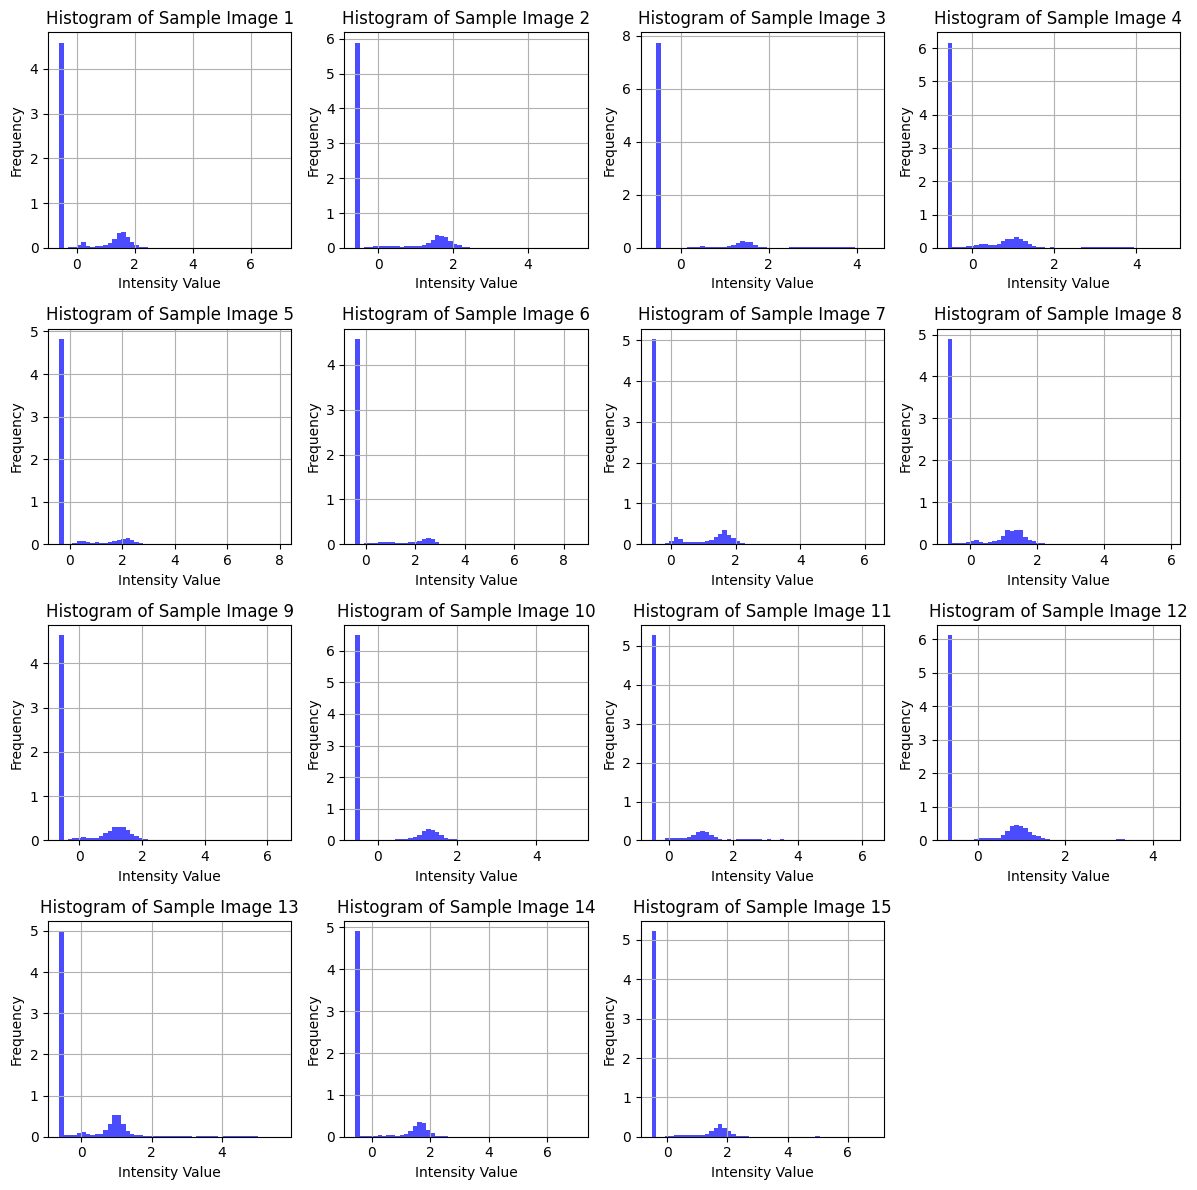

In [6]:
title = "Histogram of Sample Image"
plt.figure(figsize=(12, 12))
for idx in range(15):
    plt.subplot(4, 4, idx + 1)
    plot_histogram(sample_images[idx], f"{title} {idx+1}")
plt.tight_layout()
plt.show()

## Gaussian Mixture Model

$$
f_{\mathbf{x}}(\mathbf{x}) = \frac{1}{\sqrt{(2\pi)^d |\boldsymbol{\Sigma}|}} \exp\left(-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^T \boldsymbol{\Sigma}^{-1} (\mathbf{x}-\boldsymbol{\mu})\right)
$$
$$
\text{if } \boldsymbol{\Sigma} = \sigma^2 \mathbf{I} \text{ then the distribution is spherical}
$$
$$
\text{if }  \boldsymbol{\Sigma} \text{ is diagonal but not a constant product of I then the the variables are uncorrelated, and the ellipsoid's axes are aligned with the coordinate axes.}
$$

In [7]:
def gaussian_pdf(x, mean, cov, reg_covar=1e-6):
    """
    Multivariate Gaussian probability density function.
    x: (d) sample
    mean: (d)
    cov: (d,d) covariance
    """
    d = mean.shape[0]
    cov = cov + reg_covar * np.eye(d)  
    det_cov = np.linalg.det(cov)
    if det_cov <= 0:
        det_cov = reg_covar
    inv_cov = np.linalg.inv(cov)  
    diff = x - mean
    exponent = -0.5 * diff.T @ inv_cov @ diff
    coeff = 1 / np.sqrt((2 * np.pi) ** d * det_cov)
    return coeff * np.exp(exponent)

In [8]:
def k_means(X, K, max_iter, seed = 21):
    np.random.seed(seed)
    n_sample, n_feature = X.shape
    idx = np.random.choice(n_sample, K, replace=False)
    means = X[idx]
    for it in range(max_iter):
        labels = np.zeros(n_sample, dtype=int)
        for i in range(n_sample):
            dists = [np.linalg.norm(X[i] - means[k]) for k in range(K)]
            labels[i] = np.argmin(dists)
        new_means = np.zeros((K, n_feature))
        for k in range(K):
            points = X[labels == k]
            if len(points) > 0: 
                new_means[k] = points.mean(axis=0)
            else:
                new_means[k] = means[k]
        
        # Convergence check
        if np.allclose(means, new_means):
            # print(f"Converged at {it+1}")
            break
        means = new_means
    #Calculate the variance of each cluster
    variances = np.zeros(K)
    for k in range(K):
        points = X[labels == k]
        if len(points) > 0:
            variances[k] = np.var(points, axis=0).mean()  # Average variance across all features
        else:
            variances[k] = 0.0  # No points assigned to this cluster
    return means, labels, variances


In [9]:
method = 'zscore'
X_list = []
for img in sample_images:
    X_list.append((img).reshape(-1, 1))
X = np.vstack(X_list)   # shape (sum of all pixels, 1)
X_norm = normalize_intensity(X, method=method) 

In [10]:
K = 4
means, labels, variances = k_means(X_norm,K, max_iter=50, seed=21)

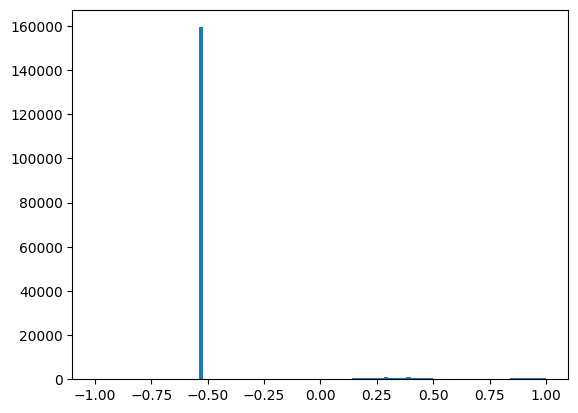

In [11]:
plt.hist(X_norm,bins=100, range=(-1,1))
plt.show()

In [12]:
print(np.argmin(means))
print(means)
print(labels.shape)  
print(variances)

2
[[ 1.70691371]
 [ 4.39614582]
 [-0.52054727]
 [ 0.53783882]]
(224000,)
[0.14385207 0.81454265 0.00315367 0.10227554]


In [ ]:
def GaussianMixtureModel(X, K, max_iter=100, tol=1e-4, reg_covar=1e-6, verbose=False):
    
    n_samples, n_features = X.shape
    np.random.seed(21)    
    covariances = []
    for k in range(K):
        if n_features == 1:  # 1D data
            covariances.append(np.array([[variances[k] + reg_covar]]))
        else:  # multi-D
            covariances.append(np.diag(variances[k] + reg_covar))  # diagonal covariance
    covariances = np.array(covariances)
    weights = np.ones(K) / K #Equal initial weights. This means that initially, each Gaussian component is assumed to contribute equally to the overall mixture.
    log_likelihoods = [] #To store the log-likelihood at each iteration

    for it in range(max_iter):
        # E-step: responsibilities
        responsibilities = np.zeros((n_samples, K)) #One-hot encoded responsibilities. Each row corresponds to a probability distribution over the K components for a given data point. Shape (N,K)
        for n in range(n_samples): #Iterate over each data point
            for k in range(K): #Iterate over each Gaussian component
                responsibilities[n, k] = weights[k] * gaussian_pdf(X[n], means[k], covariances[k], reg_covar) #Calculate the responsibility of component k for data point n
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)  # When axis=1, it means we are summing across the columns for each row. keepdims=True ensures that the result 
        #maintains the same number of dimensions as the input array, which is important for broadcasting during division.

        # M-step: update parameters
        Nk = responsibilities.sum(axis=0)  # effective number of points per cluster. Summing each column to get the total responsibility assigned to each cluster across all data points. Shape (K,)[N1,N2,...,Nk]
        for k in range(K):
            # Update means
            means[k] = (responsibilities[:, k][:, np.newaxis] * X).sum(axis=0) / Nk[k] #New mean is the weighted average of all data points, weighted by their responsibilities to cluster k. 
            #np.newaxis is used to convert the 1D array responsibilities[:, k] of shape (N,) into a 2D column vector of shape (N, 1). This allows for proper broadcasting when multiplying with X, which has shape (N, d).
            # Update covariances
            diff = X - means[k]
            covariances[k] = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / Nk[k] #Weighted covariance calculation
            #Here, responsibilities[:, k][:, np.newaxis] creates a column vector of shape (N, 1) from the responsibilities for cluster k. This allows for element-wise multiplication with diff, which has shape (N, d).
            # The result is a weighted version of diff, where each row (data point) is scaled by its responsibility to cluster k. 
            
            # Update weights
            weights[k] = Nk[k] / n_samples

        # Compute log-likelihood
        log_likelihood = 0
        for n in range(n_samples):
            prob = 0
            for k in range(K):
                prob += weights[k] * gaussian_pdf(X[n], means[k], covariances[k], reg_covar) #Total probability of data point n under the mixture model. p(x) = sum of p(x|zk =1)p(zk=1) over all k
            log_likelihood += np.log(prob + 1e-12) #Adding a small constant to avoid log(0)
        log_likelihoods.append(log_likelihood)

        if verbose:
            print(f"Iteration {it+1}, log-likelihood = {log_likelihood:.6f}")

        # Convergence check
        if it > 0 and abs(log_likelihood - log_likelihoods[-2]) < tol: #If the change in log-likelihood between iterations is less than tolerance, we consider the algorithm to have converged.
            if verbose:
                print("Converged.")
            break

    return means, covariances, weights, responsibilities, log_likelihoods


In [14]:
means, covariances, weights, responsibilities, log_likelihoods = GaussianMixtureModel(X_norm, K, max_iter=200, tol=1e-4, verbose=True)

Iteration 1, log-likelihood = 414546.456284
Iteration 2, log-likelihood = 724287.225395
Iteration 3, log-likelihood = 738672.474505
Iteration 4, log-likelihood = 738770.391597
Iteration 5, log-likelihood = 738848.169080
Iteration 6, log-likelihood = 738921.897118
Iteration 7, log-likelihood = 738991.660134
Iteration 8, log-likelihood = 739057.122638
Iteration 9, log-likelihood = 739117.915330
Iteration 10, log-likelihood = 739173.724225
Iteration 11, log-likelihood = 739224.322864
Iteration 12, log-likelihood = 739269.591761
Iteration 13, log-likelihood = 739309.531100
Iteration 14, log-likelihood = 739344.265122
Iteration 15, log-likelihood = 739374.036540
Iteration 16, log-likelihood = 739399.190683
Iteration 17, log-likelihood = 739420.151337
Iteration 18, log-likelihood = 739437.391551
Iteration 19, log-likelihood = 739451.403657
Iteration 20, log-likelihood = 739462.672213
Iteration 21, log-likelihood = 739471.652564
Iteration 22, log-likelihood = 739478.756256
Iteration 23, log-l

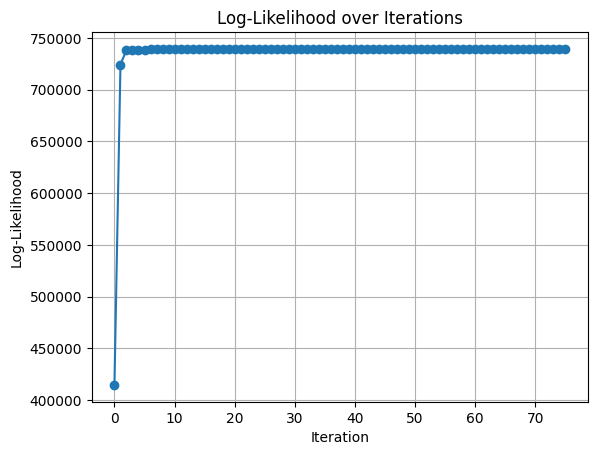

In [15]:
plt.plot(log_likelihoods, marker='o')
plt.title("Log-Likelihood over Iterations")
plt.xlabel("Iteration")
plt.ylabel("Log-Likelihood")
plt.grid()
plt.show()

In [16]:
print(f"Shape of Means are {means.shape}", sep=" ")
print(f"Shape of Covariances are {covariances.shape}")
print(f"weights {weights}")
print(f"Responsibilities {responsibilities.shape}")  # (N, K)

Shape of Means are (4, 1)
Shape of Covariances are (4, 1, 1)
weights [0.18263743 0.02000577 0.71165505 0.08570176]
Responsibilities (224000, 4)


In [ ]:
def select_infarct_cluster(means, segmented, image, min_frac, max_frac):
    H, W = image.shape
    Npix = H * W
    K = means.shape[0]

    cluster_mean_intensity = []
    cluster_sizes = []

    for k in range(K):
        mask = (segmented == k)
        cluster_sizes.append(mask.sum())
        if mask.sum() == 0:
            cluster_mean_intensity.append(-np.inf)
        else:
            cluster_mean_intensity.append(np.mean(image[mask]))
    
    cluster_mean_intensity = np.array(cluster_mean_intensity)
    cluster_sizes = np.array(cluster_sizes)

    order = np.argsort(np.array(cluster_mean_intensity).ravel())[::-1]

    for idx in order:
        frac = cluster_sizes[idx] / Npix
        if min_frac <= frac <= max_frac:
            print(f"Chosen cluster {idx} with size fraction {frac:.4f}")
            return idx

    print(f"Fallback: Chosen cluster {order[0]} with size fraction {cluster_sizes[order[0]] / Npix:.4f}")
    return order[0]


In [ ]:
from scipy.ndimage import binary_fill_holes
def postprocess_mask(binary_mask, min_area=4, closing_radius=1.5):
    # remove very small specks
    binary_mask = (binary_mask > 0).astype(np.uint8)
    cleaned = morphology.remove_small_objects(binary_mask.astype(bool), min_size=min_area)
    
    selem = morphology.disk(closing_radius)
    cleaned = morphology.opening(cleaned, selem) # remove noise before closing

    cleaned = binary_fill_holes(cleaned)    # fill holes
    closed = morphology.closing(cleaned, selem)

    return closed.astype(np.uint8)


In [ ]:
def assign_gmm_labels(image, means, covariances, weights, reg_covar=1e-6):
    img_n = normalize_intensity(image, method=method)
    X_local = img_n.reshape(-1, 1)  # shape (N, 1)
    N = X_local.shape[0]
    K = means.shape[0]
    responsibilities = np.zeros((N, K))
    for n in range(N):
        for k in range(K):
            responsibilities[n, k] = weights[k] * gaussian_pdf(X_local[n], means[k], covariances[k], reg_covar)
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    labels = np.argmax(responsibilities, axis=1)
    return img_n,labels.reshape(image.shape)

In [20]:
def dice_coefficient(gt, pred, eps=1e-8):
    gt = gt.astype(bool)
    pred = pred.astype(bool)
    inter = np.logical_and(gt, pred).sum()
    return 2.0 * inter / (gt.sum() + pred.sum() + eps)

In [ ]:
def lesion_wise_f1_and_counts(gt, pred, iou_threshold=0.08):
    gt_labels = measure.label(gt.astype(bool))
    pred_labels = measure.label(pred.astype(bool))
    gt_props = measure.regionprops(gt_labels)
    pred_props = measure.regionprops(pred_labels)

    GT_n = len(gt_props)
    P_n = len(pred_props)
    matched_gt = 0
    matched_pred = 0

    # build bounding boxes and pixel sets for efficiency
    pred_masks = []
    for p in pred_props:
        pred_masks.append((p.label, pred_labels == p.label))

    for g in gt_props:
        gmask = (gt_labels == g.label)
        matched = False
        for plabel, pmask in pred_masks:
            inter = np.logical_and(gmask, pmask).sum()
            union = np.logical_or(gmask, pmask).sum()
            iou = inter / union if union > 0 else 0.0
            if iou >= iou_threshold:
                matched = True
                break
        if matched:
            matched_gt += 1

    # predicted matched count
    gt_masks = []
    for g in gt_props:
        gt_masks.append((g.label, gt_labels == g.label))
    for p in pred_props:
        pmask = (pred_labels == p.label)
        matched = False
        for glabel, gmask in gt_masks:
            inter = np.logical_and(gmask, pmask).sum()
            union = np.logical_or(gmask, pmask).sum()
            iou = inter / union if union > 0 else 0.0
            if iou >= iou_threshold:
                matched = True
                break
        if matched:
            matched_pred += 1

    precision = matched_pred / (P_n + 1e-8)
    recall = matched_gt / (GT_n + 1e-8)
    f1 = 2 * precision * recall / (precision + recall + 1e-8) if (precision+recall)>0 else 0.0
    return f1, GT_n, P_n

In [ ]:
def segment_slice_with_gmm(slice_img, K, min_frac, max_frac, verbose=False):
    H, W = slice_img.shape
    img_n = normalize_intensity(slice_img, method=method)
    # Unpack the output of assign_gmm_labels
    _, labels = assign_gmm_labels(slice_img, means, covariances, weights)
    labels = np.asarray(labels).reshape(H, W)  # Ensure shape and type

    cluster_masks = []
    for k in range(K):
        mask = (labels == k).astype(np.uint8)  # Use np.uint8
        cluster_masks.append(mask)

    # select infarct cluster using rule
    chosen_idx = select_infarct_cluster(means, labels, img_n, min_frac=min_frac, max_frac=max_frac)
    chosen_mask = cluster_masks[chosen_idx].astype(np.uint8)

    # Postprocess
    final_mask = postprocess_mask(chosen_mask)

    return final_mask

In [29]:
# DICE and lesion-wise F1 evaluation on sample images
abs_diffs = []
dice_scores = []
f1_scores = []
for i in range(len(sample_images)):
    img = sample_images[i]
    gt_mask = sample_masks[i]
    pred_mask = segment_slice_with_gmm(img, K,min_frac=0.0005, max_frac=0.15)
    dice = dice_coefficient(gt_mask, pred_mask)
    f1, GT_n, P_n = lesion_wise_f1_and_counts(gt_mask, pred_mask)
    abs_diff = abs(GT_n - P_n)
    abs_diffs.append(abs_diff)
    dice_scores.append(dice)
    f1_scores.append(f1)
    print(f"Sample Image {i+1}: Dice={dice:.4f}, Lesion-wise F1={f1:.4f}, abs diff = {abs_diff}")
print(f"Average Dice on Sample Images: {np.mean(dice_scores):.4f}")
print(f"Average Lesion-wise F1 on Sample Images: {np.mean(f1_scores):.4f}")
print(f"Average Absolute Difference in Lesion Size on Sample Images: {np.mean(abs_diffs):.4f}")


Chosen cluster 1 with size fraction 0.0065
Sample Image 1: Dice=0.7538, Lesion-wise F1=0.8571, abs diff = 1
Chosen cluster 1 with size fraction 0.0021
Sample Image 2: Dice=0.3459, Lesion-wise F1=0.3333, abs diff = 19
Chosen cluster 1 with size fraction 0.0385
Sample Image 3: Dice=0.7921, Lesion-wise F1=0.6667, abs diff = 1
Chosen cluster 1 with size fraction 0.0379
Sample Image 4: Dice=0.8714, Lesion-wise F1=0.6667, abs diff = 1
Chosen cluster 1 with size fraction 0.0121
Sample Image 5: Dice=0.8720, Lesion-wise F1=0.4444, abs diff = 5
Chosen cluster 1 with size fraction 0.0196
Sample Image 6: Dice=0.6984, Lesion-wise F1=0.6667, abs diff = 4
Chosen cluster 1 with size fraction 0.0098
Sample Image 7: Dice=0.8773, Lesion-wise F1=1.0000, abs diff = 0
Chosen cluster 1 with size fraction 0.0091
Sample Image 8: Dice=0.8485, Lesion-wise F1=1.0000, abs diff = 0
Chosen cluster 1 with size fraction 0.0091
Sample Image 9: Dice=0.9106, Lesion-wise F1=1.0000, abs diff = 0
Chosen cluster 1 with size 

In [27]:
TestResults = []
# DICE and lesion-wise F1 evaluation on test images, and lesion wise absolute element difference
dice_scores = []
f1_scores = []
abs_diffs = []

# make sure TestResults directory exists
os.makedirs("TestResults", exist_ok=True)

for i in range(len(test_images)):
    img = test_images[i]
    gt_mask = test_masks[i]
    start_time = time.time()
    pred_mask = segment_slice_with_gmm(img,K,min_frac=0.0005,max_frac=0.15)


    dice = dice_coefficient(gt_mask, pred_mask)
    f1, GT_n, P_n = lesion_wise_f1_and_counts(gt_mask, pred_mask)
    abs_diff = abs(GT_n - P_n)

    dice_scores.append(dice)
    f1_scores.append(f1)
    abs_diffs.append(abs_diff)

    # Save result
    TestResults.append(pred_mask)
    pred_nifti = nib.Nifti1Image(pred_mask.astype(np.uint8), affine=np.eye(4))
    nib.save(pred_nifti, os.path.join("TestResults", f"Test{i+1}-mask.nii.gz"))

    print(f"Test Image {i+1}: Dice={dice:.4f}, Lesion-wise F1={f1:.4f}, "
          f"GT lesions={GT_n}, Pred lesions={P_n}, |GT-Pred|={abs_diff}")

print(f"Average Dice on Test Images: {np.mean(dice_scores):.4f}")
print(f"Average Lesion-wise F1 on Test Images: {np.mean(f1_scores):.4f}")
print(f"Average |GT-Pred| on Test Images: {np.mean(abs_diffs):.4f}")


Chosen cluster 1 with size fraction 0.0200
Test Image 1: Dice=0.8184, Lesion-wise F1=0.6667, GT lesions=2, Pred lesions=1, |GT-Pred|=1
Chosen cluster 1 with size fraction 0.0087
Test Image 2: Dice=0.8016, Lesion-wise F1=0.8000, GT lesions=3, Pred lesions=2, |GT-Pred|=1
Chosen cluster 1 with size fraction 0.0161
Test Image 3: Dice=0.9496, Lesion-wise F1=1.0000, GT lesions=2, Pred lesions=2, |GT-Pred|=0
Chosen cluster 1 with size fraction 0.0085
Test Image 4: Dice=0.8861, Lesion-wise F1=1.0000, GT lesions=1, Pred lesions=1, |GT-Pred|=0
Chosen cluster 1 with size fraction 0.0007
Test Image 5: Dice=0.6333, Lesion-wise F1=0.8000, GT lesions=3, Pred lesions=2, |GT-Pred|=1
Chosen cluster 1 with size fraction 0.0031
Test Image 6: Dice=0.7273, Lesion-wise F1=1.0000, GT lesions=3, Pred lesions=3, |GT-Pred|=0
Chosen cluster 1 with size fraction 0.0158
Test Image 7: Dice=0.9314, Lesion-wise F1=0.5000, GT lesions=1, Pred lesions=3, |GT-Pred|=2
Chosen cluster 1 with size fraction 0.0066
Test Image 8

Chosen cluster 1 with size fraction 0.0065
Chosen cluster 1 with size fraction 0.0021
Chosen cluster 1 with size fraction 0.0385
Chosen cluster 1 with size fraction 0.0379
Chosen cluster 1 with size fraction 0.0121
Chosen cluster 1 with size fraction 0.0196
Chosen cluster 1 with size fraction 0.0098
Chosen cluster 1 with size fraction 0.0091
Chosen cluster 1 with size fraction 0.0091
Chosen cluster 1 with size fraction 0.0253
Chosen cluster 1 with size fraction 0.0346
Chosen cluster 1 with size fraction 0.0277
Chosen cluster 1 with size fraction 0.0239
Chosen cluster 1 with size fraction 0.0068
Chosen cluster 1 with size fraction 0.0079


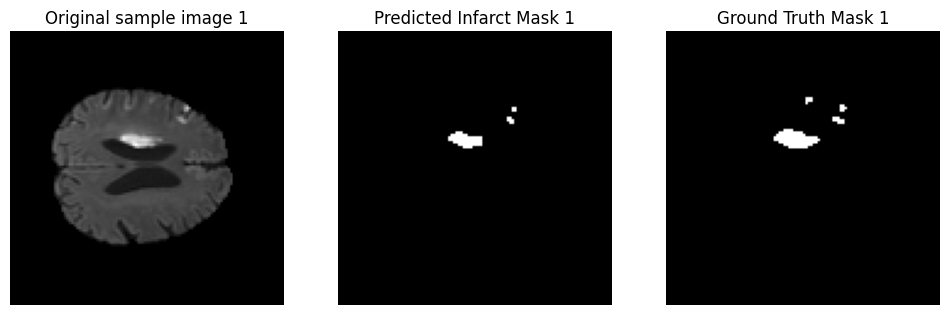

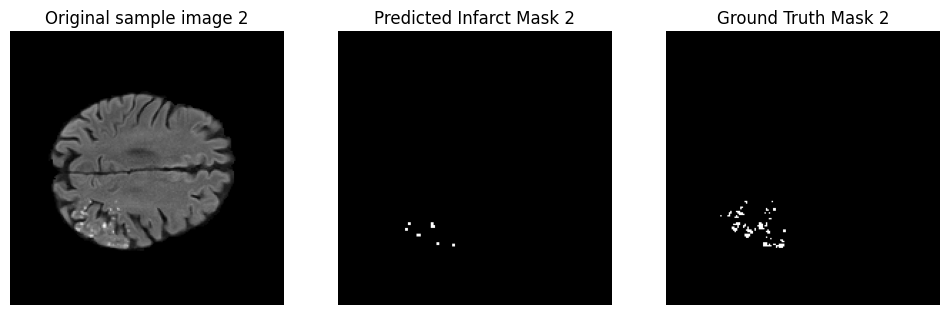

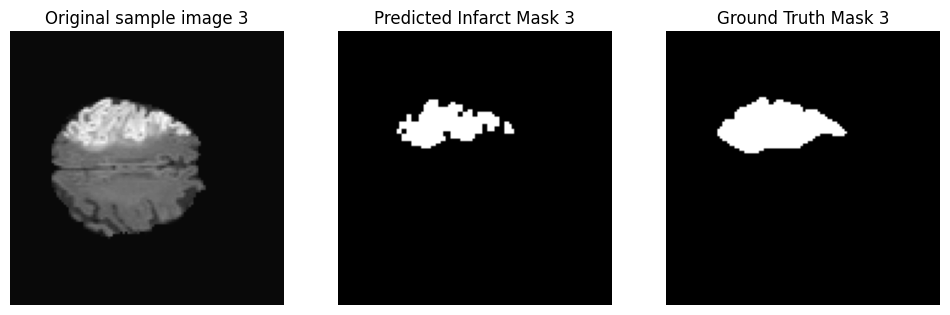

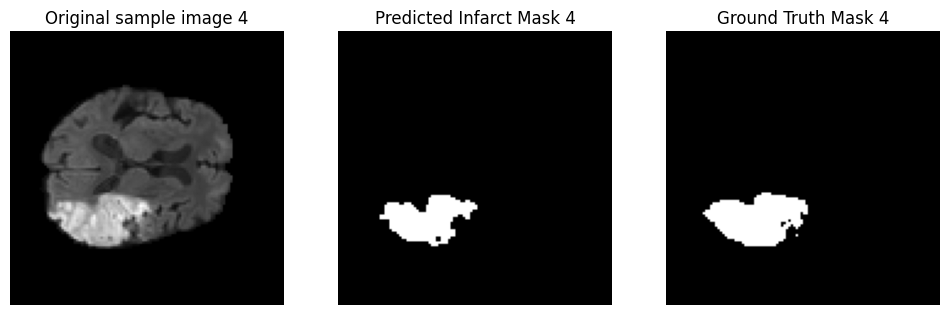

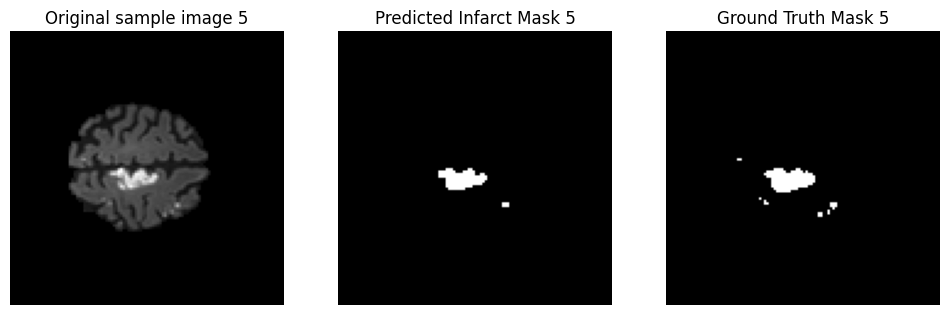

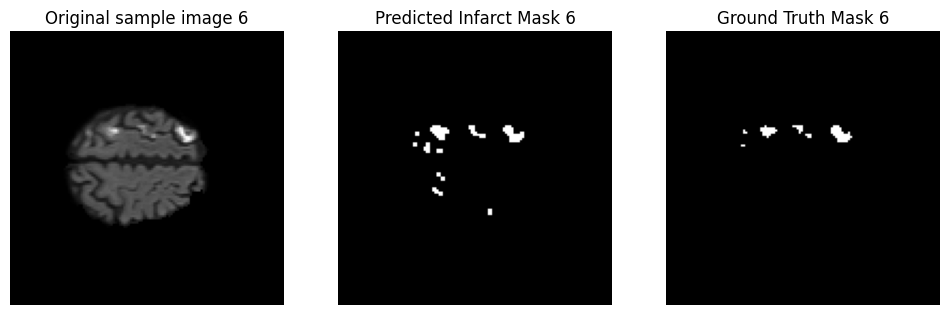

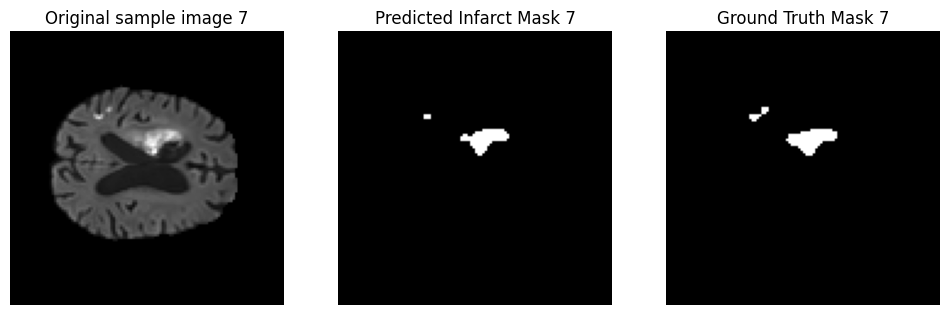

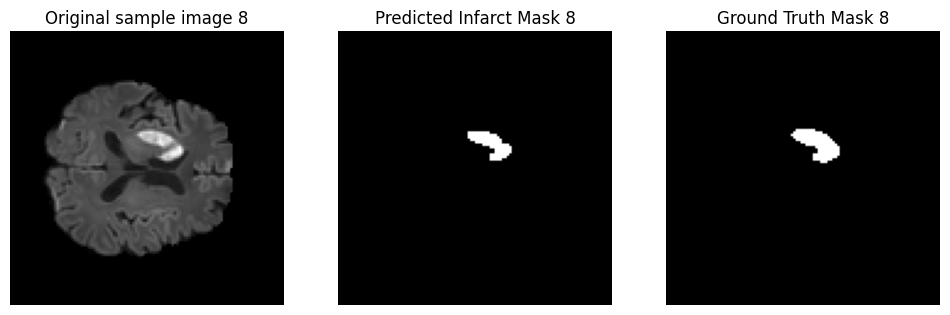

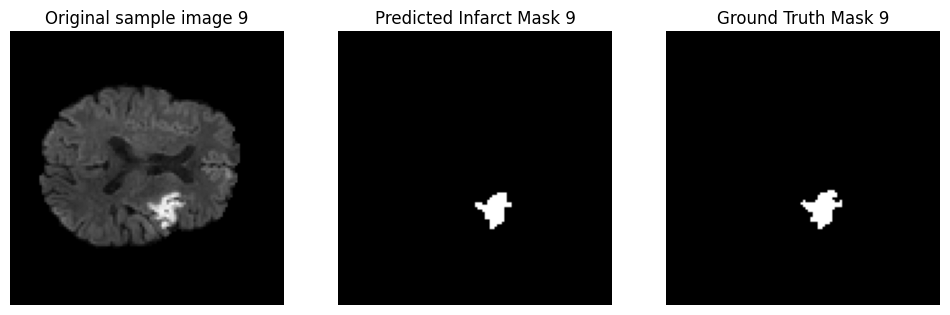

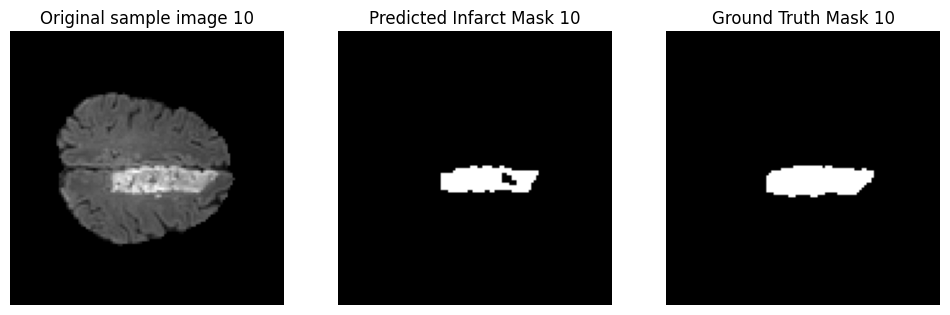

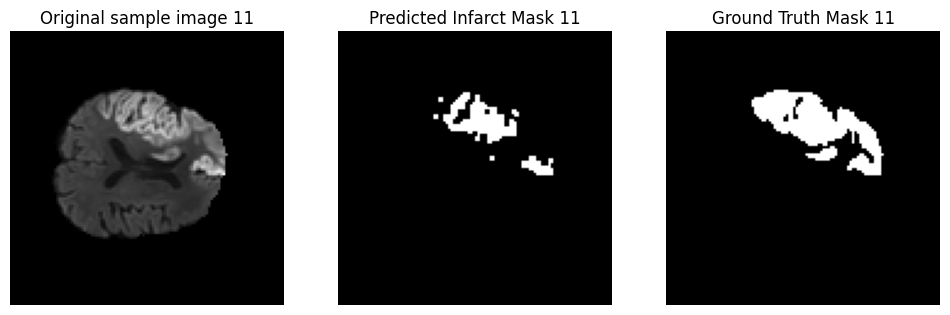

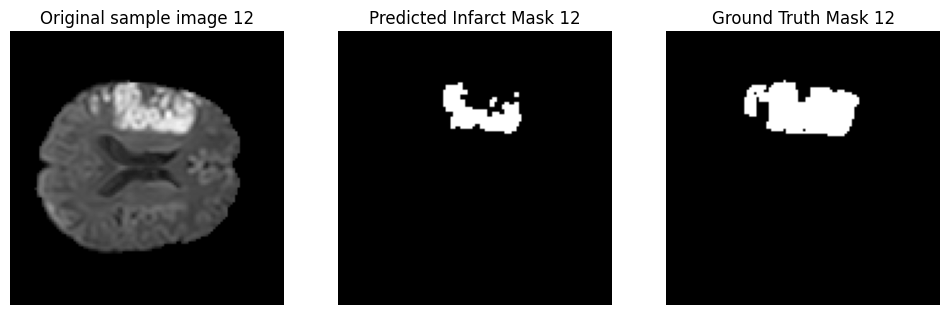

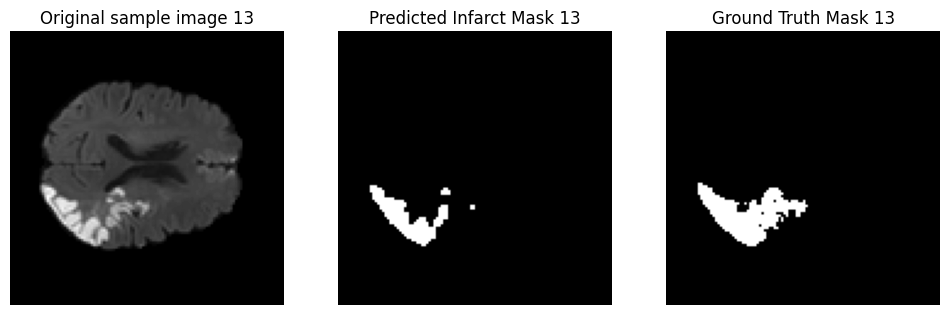

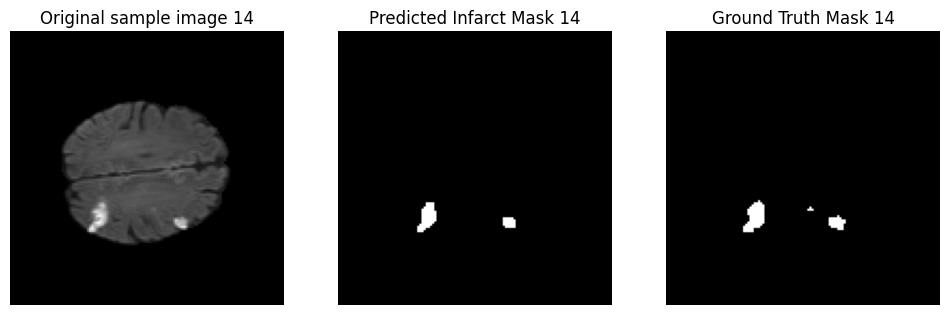

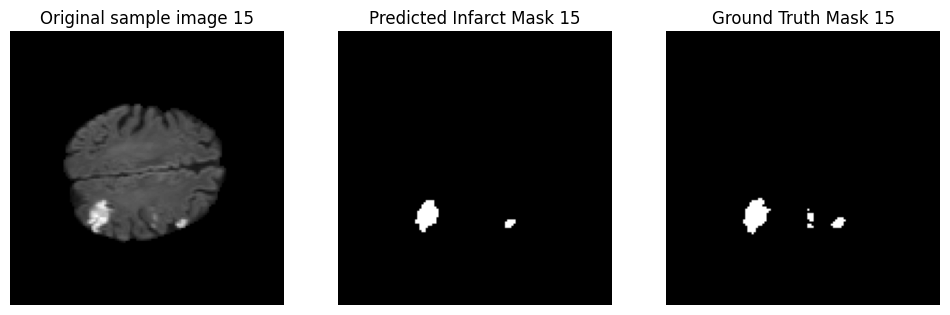

In [25]:
for i in range(len(sample_images)):
    img = sample_images[i]
    gt_mask = sample_masks[i]
    pred_mask = segment_slice_with_gmm(img, K, min_frac=0.0005, max_frac=0.15)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title(f"Original sample image {i+1}")
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.axis("off")
    plt.title("Predicted Infarct Mask " + str(i+1))
    plt.subplot(1, 3, 3)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask " + str(i+1))
    plt.axis("off")
plt.show()

Chosen cluster 1 with size fraction 0.0200
Chosen cluster 1 with size fraction 0.0087
Chosen cluster 1 with size fraction 0.0161
Chosen cluster 1 with size fraction 0.0085
Chosen cluster 1 with size fraction 0.0007
Chosen cluster 1 with size fraction 0.0031
Chosen cluster 1 with size fraction 0.0158
Chosen cluster 1 with size fraction 0.0066
Chosen cluster 1 with size fraction 0.0047
Chosen cluster 1 with size fraction 0.0056
Chosen cluster 1 with size fraction 0.0108
Chosen cluster 1 with size fraction 0.0121
Chosen cluster 1 with size fraction 0.0335
Chosen cluster 1 with size fraction 0.0167
Chosen cluster 1 with size fraction 0.0222


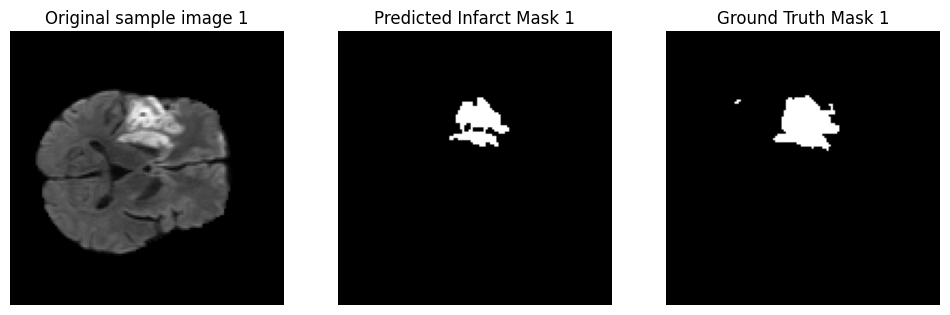

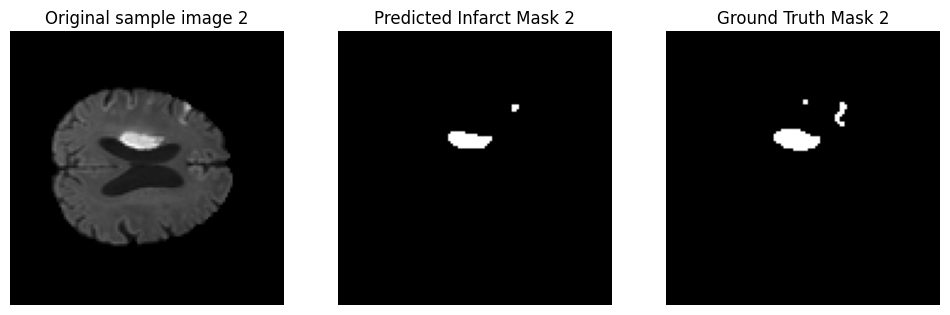

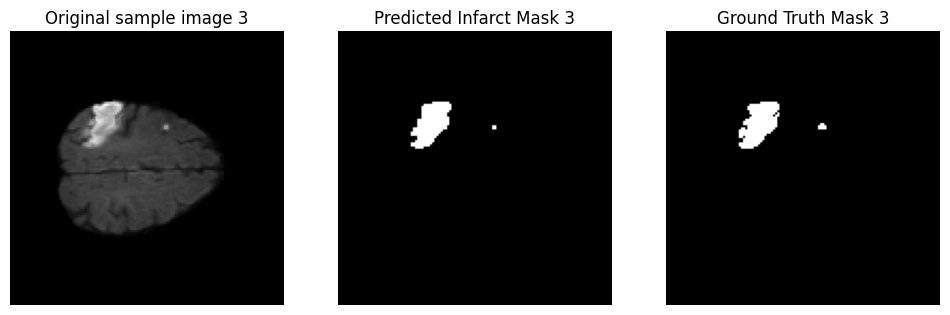

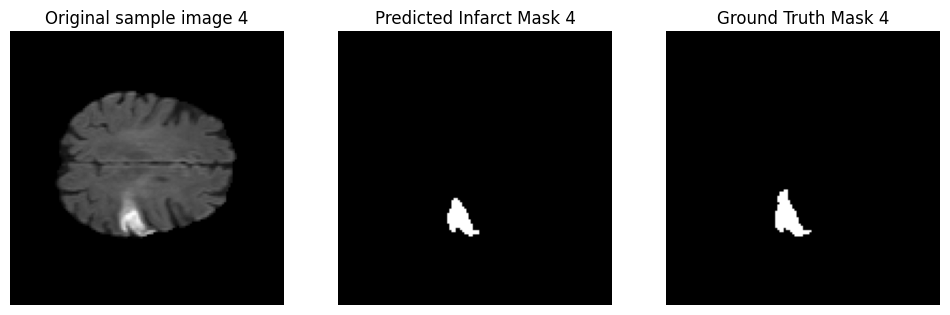

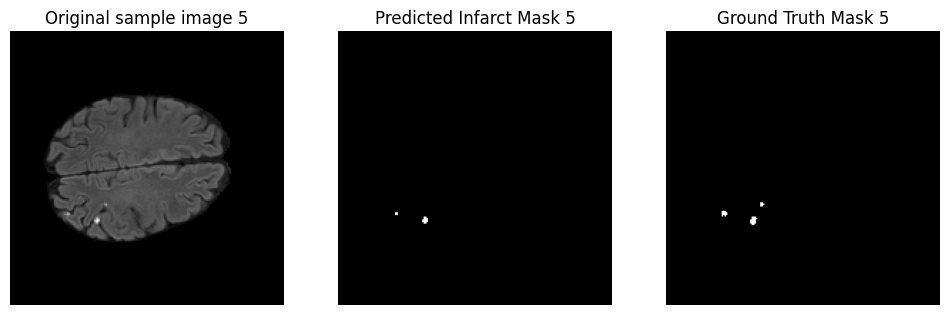

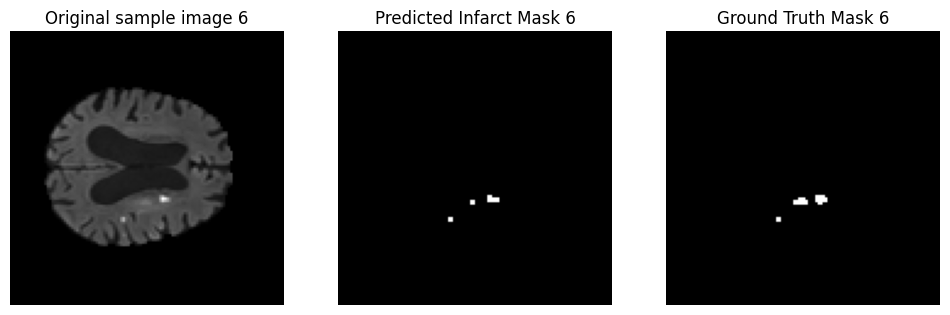

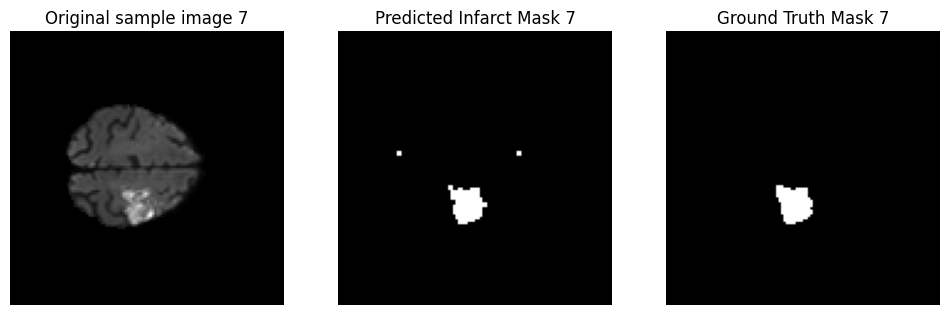

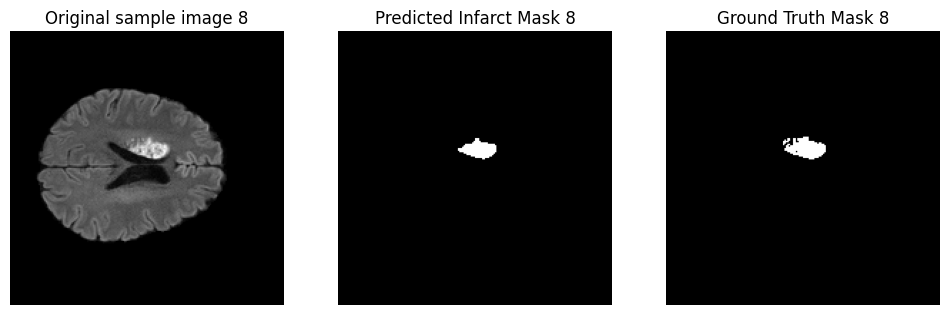

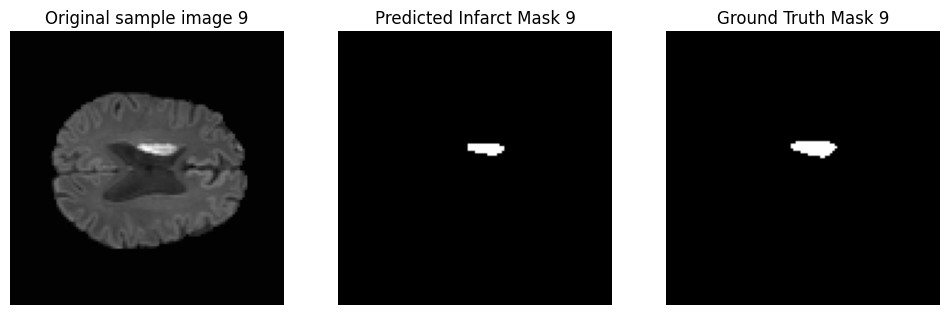

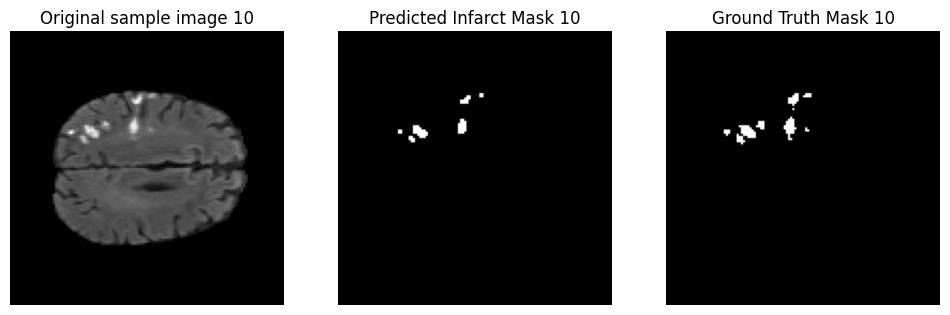

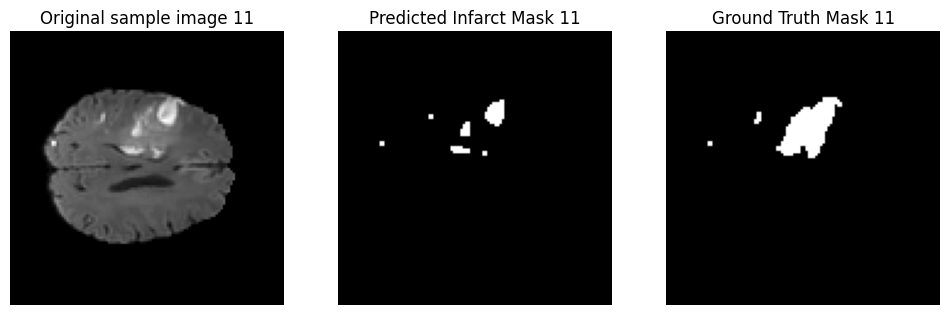

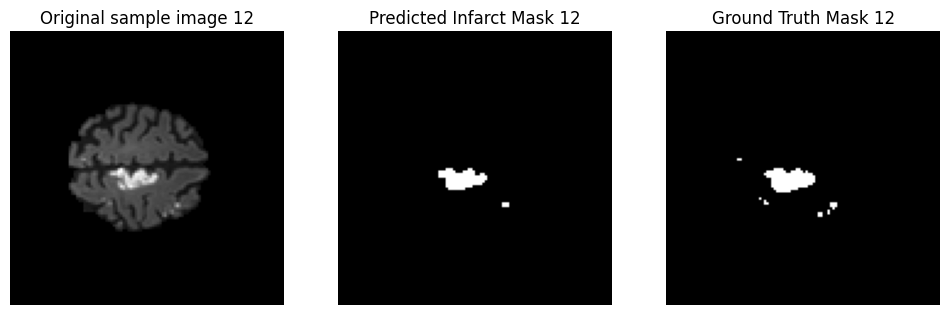

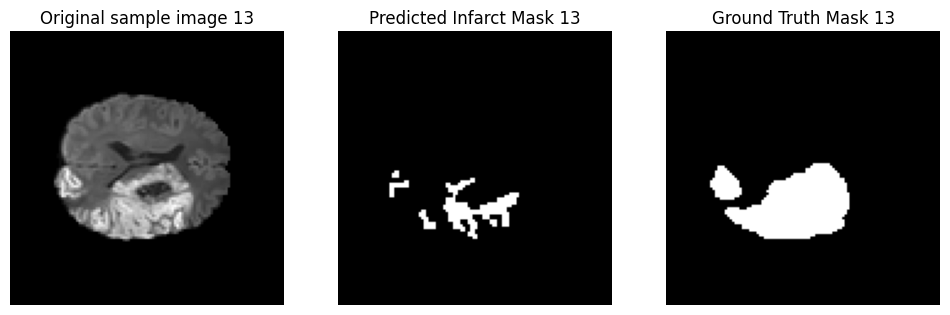

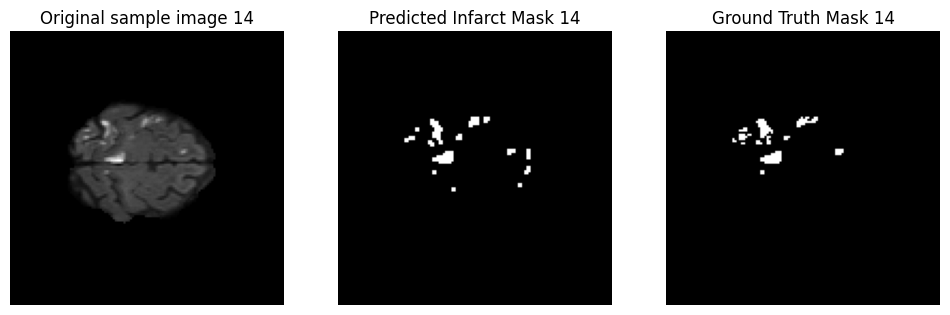

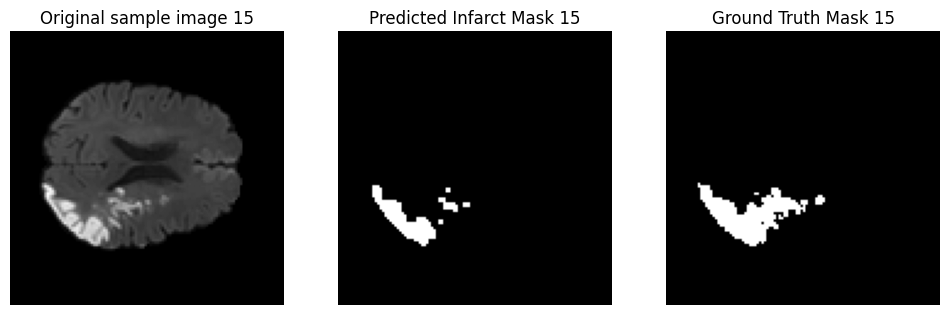

In [26]:
for i in range(len(test_images)):
    img = test_images[i]
    gt_mask = test_masks[i]
    pred_mask = segment_slice_with_gmm(img, K, min_frac=0.0005, max_frac=0.15)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title(f"Original sample image {i+1}")
    plt.subplot(1, 3, 2)
    plt.imshow(pred_mask, cmap='gray')
    plt.axis("off")
    plt.title("Predicted Infarct Mask " + str(i+1))
    plt.subplot(1, 3, 3)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask " + str(i+1))
    plt.axis("off")
plt.show()